# **Exploratory Data Analysis**

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Available data 

| Attribute | Description | Domain |
| :--- | :--- | :--- |
| *grid_id* | Identifier of a cell in Menorca's map (column and row number) | String |
| *grid_x* | **(New)** X coordinate extracted from grid_id (column index) | Integer |
| *grid_y* | **(New)** Y coordinate extracted from grid_id (row index) | Integer |
| *neighbors* | **(New)** Comma-separated string of adjacent cell IDs (8-connected Moore neighborhood) | String |
| *dominant_land_cover_name* | Dominant type of land in the cell | String |
| *human_disturbance* | **(New)** Index representing human pressure/danger (0.0 = Nature, 1.0 = Urban) | Float |
| *current_richness* | **(New)** Number of target species currently present in the cell (0 to 4) | Integer |
| *cost_adaptation_atelerix* | Cost of making some adaptations in the cell for the atelerix | Float |
| *cost_adaptation_martes* | Cost of making some adaptations in the cell for the martes martes | Float |
| *cost_adaptation_eliomys* | Cost of making some adaptations in the cell for the eliomys quercinus | Float |
| *cost_adaptation_oryctolagus* | Cost of making some adaptations in the cell for the oryctolagus cuniculus | Float |
| *cost_corridor* | Cost of preparing a single corridor in the cell | Float |
| *suitability_atelerix* | **(New)** Biological habitat quality score for *Atelerix algirus* (0.0 to 3.0) | Float |
| *suitability_martes* | **(New)** Biological habitat quality score for *Martes martes* (0.0 to 3.0) | Float |
| *suitability_eliomys* | **(New)** Biological habitat quality score for *Eliomys quercinus* (0.0 to 3.0) | Float |
| *suitability_oryctolagus* | **(New)** Biological habitat quality score for *Oryctolagus cuniculus* (0.0 to 3.0) | Float |
| *efficiency_atelerix* | **(New)** ROI metric: Ratio of Suitability / Cost of Adaptation for *Atelerix* | Float |
| *efficiency_martes* | **(New)** ROI metric: Ratio of Suitability / Cost of Adaptation for *Martes* | Float |
| *efficiency_eliomys* | **(New)** ROI metric: Ratio of Suitability / Cost of Adaptation for *Eliomys* | Float |
| *efficiency_oryctolagus* | **(New)** ROI metric: Ratio of Suitability / Cost of Adaptation for *Oryctolagus* | Float |
| *has_atelerix_algirus* | Whether or not the cell has a living colony of atelerix | Boolean |
| *has_martes_martes* | Whether or not the cell has a living colony of martes martes | Boolean |
| *has_eliomys_quercinus* | Whether or not the cell has a living colony of eliomys quercinus | Boolean |
| *has_oryctolagus_cuniculus* | Whether or not the cell has a living colony of european rabbit | Boolean |
| *geometry* | The polygon that describes the cell (Only present in the .geojson file) | Geometry |


### 1. Load Data

In [16]:
df_geojson = gpd.read_file("../2_data/processed/final_dataset.geojson") # Load GeoJSON data
df_csv = pd.read_csv("../2_data/processed/final_dataset.csv")           # Load CSV data

### 2. Analysis of Adaptation Costs

To assess the economic feasibility of habitat expansion, we analyzed the distribution of adaptation costs for each specie across the island. The following histograms display the frequency of costs (€ per unit area) required to modify a cell for a specific species.

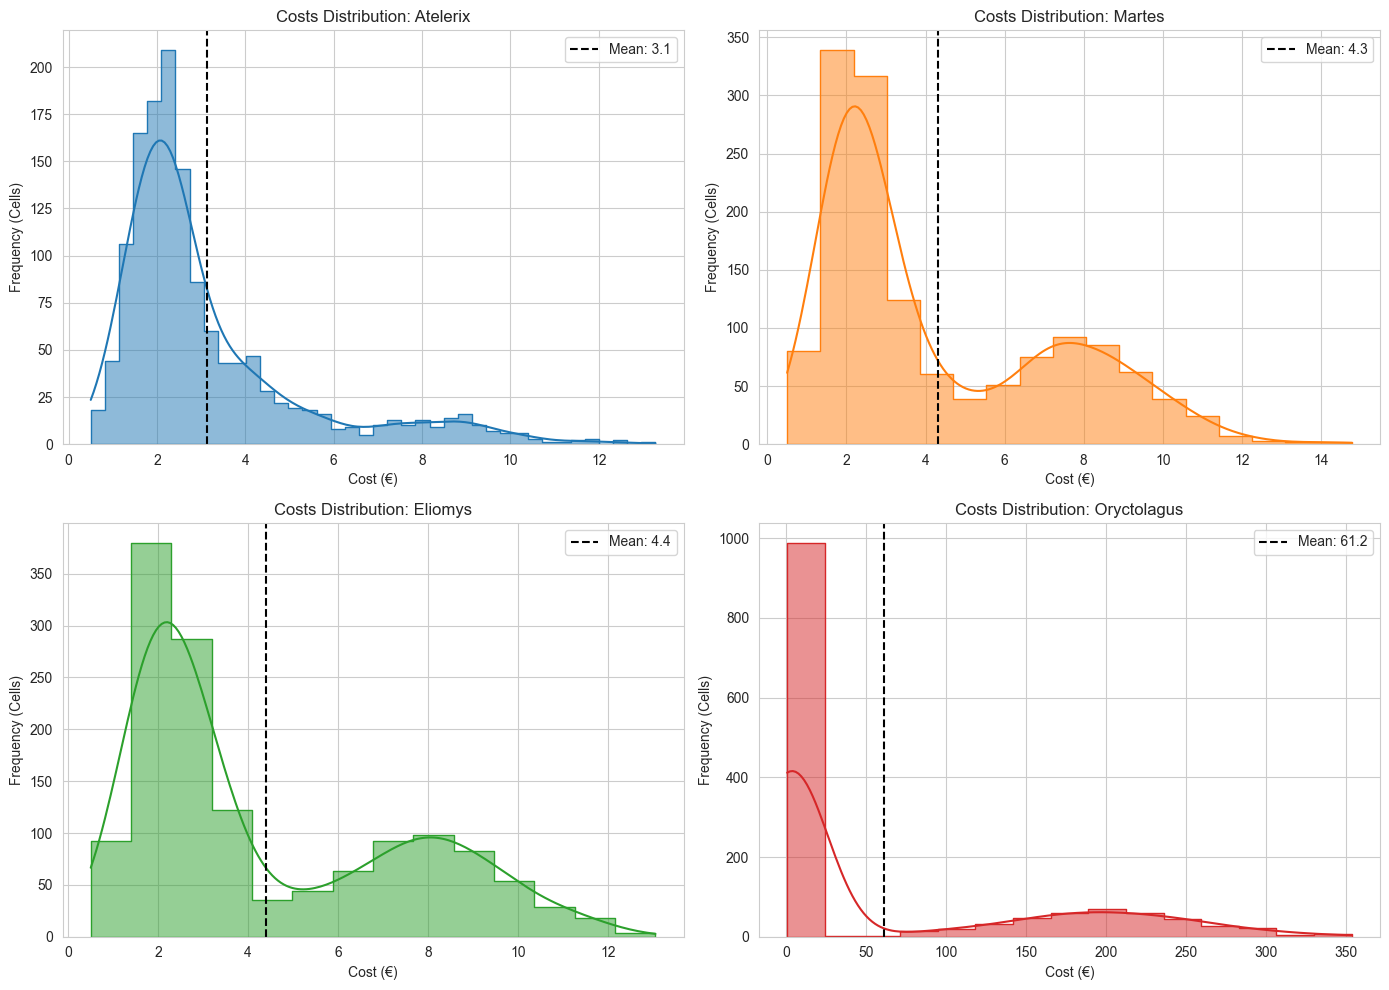

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

cost_cols = [
    'cost_adaptation_atelerix', 
    'cost_adaptation_martes', 
    'cost_adaptation_eliomys', 
    'cost_adaptation_oryctolagus'
]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, col in enumerate(cost_cols):
    species_name = col.replace('cost_adaptation_', '').capitalize()
    sns.histplot(df_csv[col], kde=True, ax=axes[i], color=colors[i], element="step")
    
    axes[i].set_title(f"Costs Distribution: {species_name}")
    axes[i].set_xlabel("Cost (€)")
    axes[i].set_ylabel("Frequency (Cells)")
    
    mean_val = df_csv[col].mean()
    axes[i].axvline(mean_val, color='k', linestyle='--', label=f'Mean: {mean_val:.1f}')
    axes[i].legend()

plt.tight_layout()
plt.savefig("../5_results/charts/costs_distribution_per_specie.png", dpi=300)
plt.show()

**Key Insights:**

1.  **Extreme Cost Disparity:** There is an important order-of-magnitude difference between the *Oryctolagus cuniculus* and the other three species. While the average adaptation cost for Hedgehogs, Martens, and Dormice ranges between **3€ and 5€**, the average cost for Rabbits is approximately **60€**, with peaks exceeding 300€.
2.  **Variance and Location Sensitivity:**
    * **Low Variance (*Atelerix, Martes, Eliomys*):** The costs for these species are relatively homogeneous and concentrated around the mean (narrow distribution). This implies that, economically, most cells are equally viable candidates for expansion.
    * **High Variance (*Oryctolagus*):** The rabbit cost distribution is highly spread out (high standard deviation). This indicates that location selection is critical for this species; choosing the wrong cell could drain the budget disproportionately compared to an optimal one.
3.  **Budgetary Implications:** The high baseline cost for *Oryctolagus* suggests that any strategy involving rabbit habitat expansion will be the primary driver of budget consumption. The optimization model will face a significant trade-off: expanding one unit of rabbit habitat could be equivalent to expanding ~15-20 units of habitat for other species.

### 3. Analysis of Ecological Efficiency (ROI)

In order to quantify the "value for money" of conservation investments, we calculated the **Ecological Efficiency Index** for each cell and species. This metric is defined as the ratio between Habitat Suitability (biological gain) and Adaptation Cost (economic investment):

$$\text{Efficiency}_{i,s} = \frac{\text{Suitability}_{i,s}}{\text{Cost}_{i,s}}$$

Higher values indicate cells that provide high-quality habitat for a low cost.

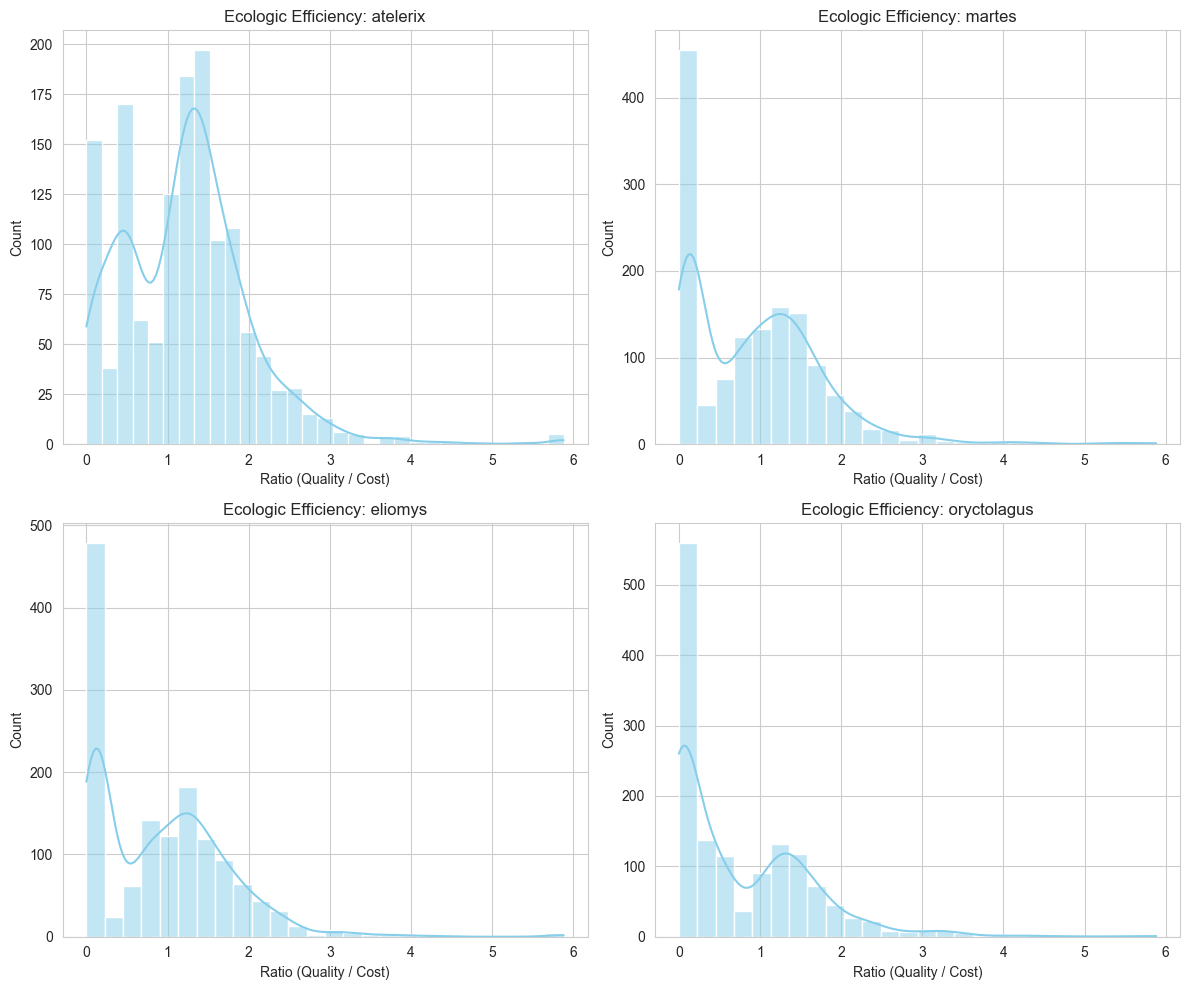

In [51]:
species = ['atelerix', 'martes', 'eliomys', 'oryctolagus']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, sp in enumerate(species):
    sns.histplot(df_csv[f'efficiency_{sp}'], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f"Ecologic Efficiency: {sp}")
    axes[i].set_xlabel("Ratio (Quality / Cost)")

plt.tight_layout()
plt.savefig("../5_results/charts/eco_efficiency_distribution_per_specie.png", dpi=300)
plt.show()

**Key Insights:**

1.  **Similarity across Species:** Contrary to the raw cost analysis, the efficiency distributions are strikingly similar across all four species. Each histogram spans a range from 0 to ~6, showing a characteristic "long tail" shape. This indicates that **viable, high-efficiency candidate cells exist for every species**, including the Rabbit (*Oryctolagus cuniculus*).
2.  **The "Bargain" Habitats:** The peaks on the right side of the histograms (Efficiency > 1.0) correspond to optimal habitats with low adaptation costs..
3.  **Nuance on Risk:** While the *Oryctolagus* distribution looks healthy (showing plenty of efficient options), we must recall the **Cost Analysis**. The Rabbit's high efficiency in specific cells (Pastures) masks the extreme risk of "wrong" cells (e.g., Urban/Forests with costs >300€). The optimization model will easily find good rabbit cells initially, but if it is forced to expand beyond these "prime" areas, efficiency will drop precipitously compared to other species.

### 4. Comprehensive Spatial Analysis: Habitat Usage & Co-occurrence

To visualize the overlap and segregation of species at a granular level, we generated a **Quadrant Map**. In this visualization, each grid cell is geometrically divided into four logical quadrants, with each species assigned to a fixed position (Top-Left: Hedgehog, Top-Right: Marten, Bottom-Left: Dormouse, Bottom-Right: Rabbit). A marker is plotted only if the species is present already.

**Key Insights:**
1.  **Incompatibility Zones:** Visual inspection reveals areas where **Marten (Red)** and **Dormouse (Green)** markers appear in the same cell. These specific cells represent high-conflict zones where predation risk is maximized, confirming the need for the exclusion constraints defined in the mathematical model.
2.  **Habitat Segregation:** The **Rabbit (Orange)** population shows a distinct spatial pattern, often clustering in open agricultural areas (Pastures) separate from the forest-dwelling species (Martens/Dormice), which aligns with the cost and suitability analysis performed earlier.

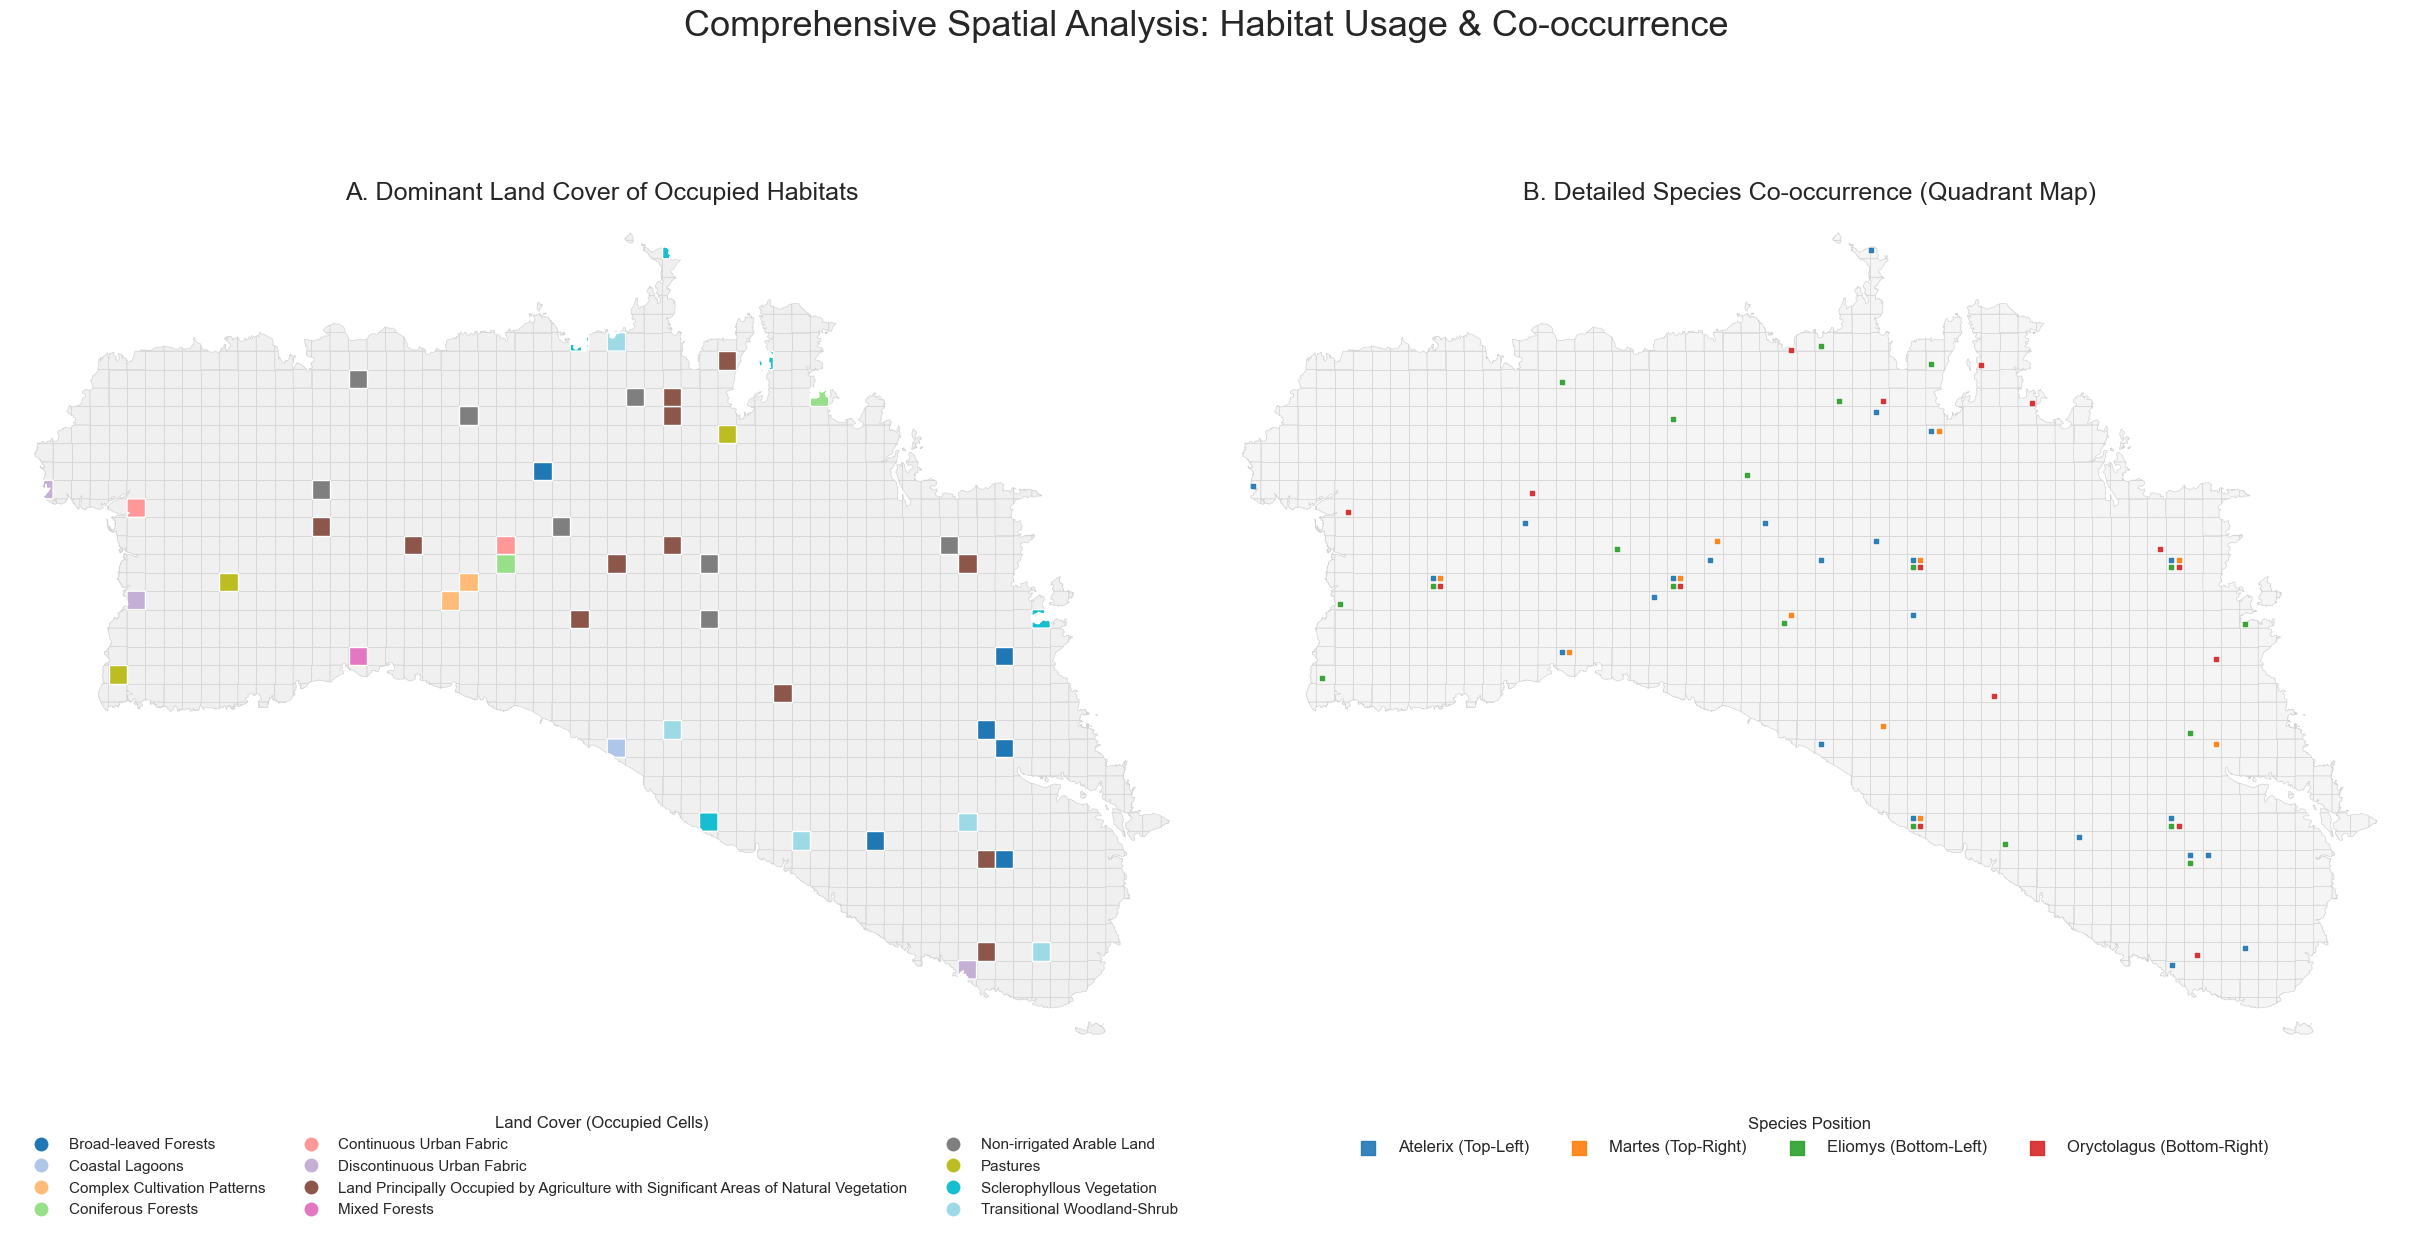

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd

# 1. Preparación
# dataset = gpd.read_file(...) # Asumo que ya lo tienes
dataset = df_geojson.to_crs(epsg=25831)

# Definir límites fijos
minx, miny, maxx, maxy = dataset.total_bounds
margin = 1000 

# Usamos constrained_layout=True que es mejor gestionando espacios que tight_layout
fig, axes = plt.subplots(1, 2, figsize=(24, 12), constrained_layout=True)

# =========================================================
# CHART 1 (LEFT): Occupied Habitat
# =========================================================
ax1 = axes[0]

dataset.plot(ax=ax1, color='#f0f0f0', edgecolor='lightgray', linewidth=0.5)
cells_with_species = dataset[dataset['current_richness'] > 0]

if not cells_with_species.empty:
    cells_with_species.plot(
        column='dominant_land_cover_name',
        cmap='tab20',
        legend=True,
        ax=ax1,
        legend_kwds={
            # CAMBIO: Ponemos la leyenda ABAJO en horizontal
            'loc': 'upper center', 
            'bbox_to_anchor': (0.5, -0.05),
            'ncol': 3,  # Dividimos la leyenda en 3 columnas para que no sea muy alta
            'title': "Land Cover (Occupied Cells)",
            'fontsize': 11,
            'title_fontsize': 12,
            'frameon': False # Quitamos el borde para que quede más limpio
        }
    )

ax1.set_title("A. Dominant Land Cover of Occupied Habitats", fontsize=18)
ax1.axis('off')
ax1.set_xlim(minx - margin, maxx + margin)
ax1.set_ylim(miny - margin, maxy + margin)
ax1.set_aspect('equal') # Forzamos proporción 1:1

# =========================================================
# CHART 2 (RIGHT): Quadrant Map
# =========================================================
ax2 = axes[1]

dataset.plot(ax=ax2, color='whitesmoke', edgecolor='lightgray', linewidth=0.5)
grid_width = (dataset.total_bounds[2] - dataset.total_bounds[0]) / (dataset['grid_x'].max() + 1)
offset = grid_width * 0.20

species_config = [
    ('has_atelerix_algirus', '#1f77b4', 'Atelerix (Top-Left)', -1, 1),
    ('has_martes_martes', '#ff7f0e', 'Martes (Top-Right)', 1, 1),
    ('has_eliomys_quercinus', '#2ca02c', 'Eliomys (Bottom-Left)', -1, -1),
    ('has_oryctolagus_cuniculus', '#d62728', 'Oryctolagus (Bottom-Right)', 1, -1)
]

for col, color, label, x_mult, y_mult in species_config:
    subset = dataset[dataset[col] == True]
    if not subset.empty:
        cents = subset.geometry.centroid
        ax2.scatter(
            cents.x + (offset * x_mult), 
            cents.y + (offset * y_mult), 
            color=color, marker='s', s=10, label=label, alpha=0.9
        )

ax2.set_title("B. Detailed Species Co-occurrence (Quadrant Map)", fontsize=18)
ax2.axis('off')

# CAMBIO: Leyenda también ABAJO para simetría
ax2.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.05), 
    ncol=4, 
    title="Species Position", 
    fontsize=12, 
    title_fontsize=12,
    markerscale=3,
    frameon=False
)

ax2.set_xlim(minx - margin, maxx + margin)
ax2.set_ylim(miny - margin, maxy + margin)
ax2.set_aspect('equal')

# Título general
plt.suptitle("Comprehensive Spatial Analysis: Habitat Usage & Co-occurrence", fontsize=26, y=1.02)

# Guardar
plt.savefig("../5_results/charts/combined_spatial_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

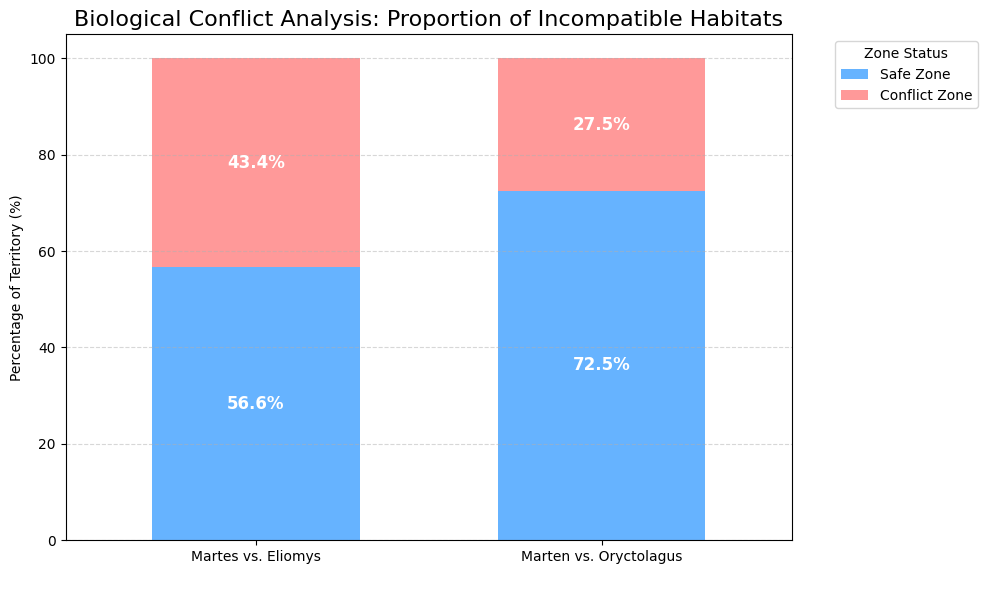

In [18]:
pct_conflict_eliomys = df_csv['conflict_martes_eliomys'].mean() * 100
pct_conflict_rabbit = df_csv['conflict_martes_oryctolagus'].mean() * 100

pct_safe_eliomys = 100 - pct_conflict_eliomys
pct_safe_rabbit = 100 - pct_conflict_rabbit

plot_data = pd.DataFrame({
    'Escenario': ['Martes vs. Eliomys\n', 'Marten vs. Oryctolagus\n'],
    'Safe Zone': [pct_safe_eliomys, pct_safe_rabbit],
    'Conflict Zone': [pct_conflict_eliomys, pct_conflict_rabbit]
})

fig, ax = plt.subplots(figsize=(10, 6))

plot_data.set_index('Escenario').plot(
    kind='bar', 
    stacked=True, 
    color=['#66b3ff', '#ff9999'], 
    ax=ax,
    width=0.6,
    rot=0 
)

for c in ax.containers:
    ax.bar_label(c, fmt='%.1f%%', label_type='center', fontsize=12, weight='bold', color='white')

plt.title("Biological Conflict Analysis: Proportion of Incompatible Habitats", fontsize=16)
plt.ylabel("Percentage of Territory (%)")
plt.xlabel("")
plt.legend(title="Zone Status", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("../5_results/charts/conflict_proportions_bar.png", dpi=300)
plt.show()

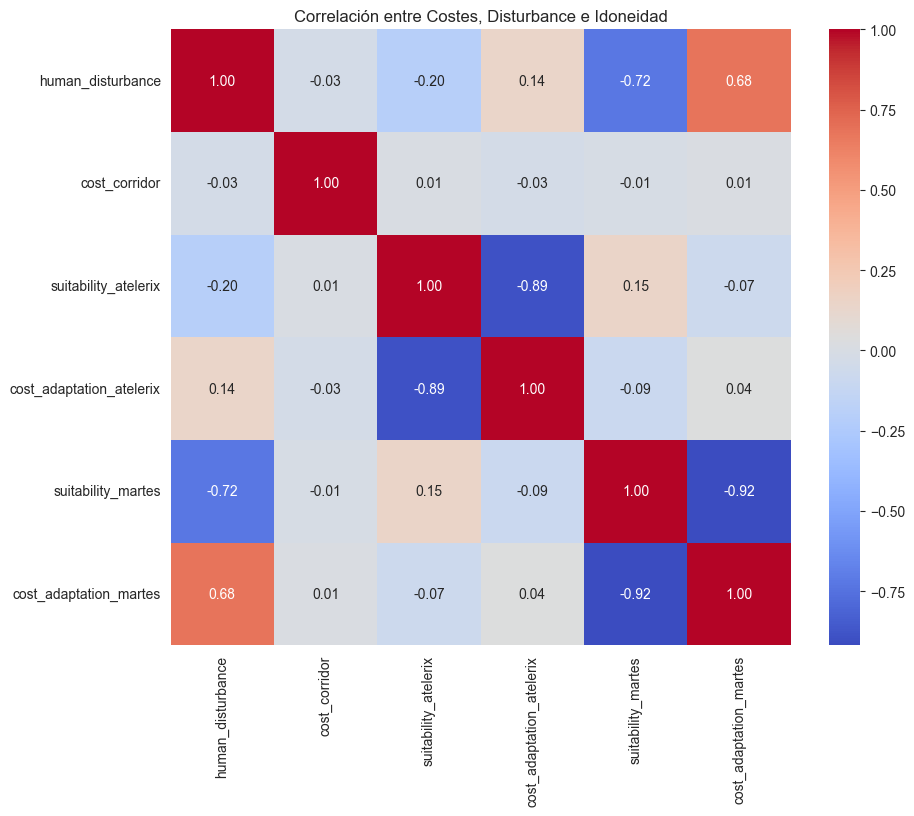

In [68]:
# Seleccionamos columnas clave
cols_corr = [
    'human_disturbance', 'cost_corridor', 
    'suitability_atelerix', 'cost_adaptation_atelerix',
    'suitability_martes', 'cost_adaptation_martes'
]
corr = df_csv[cols_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlación entre Costes, Disturbance e Idoneidad")
plt.show()

C:\Users\borog\AppData\Local\Temp\ipykernel_8552\2583361476.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='dominant_land_cover_name', order=order, palette='viridis')


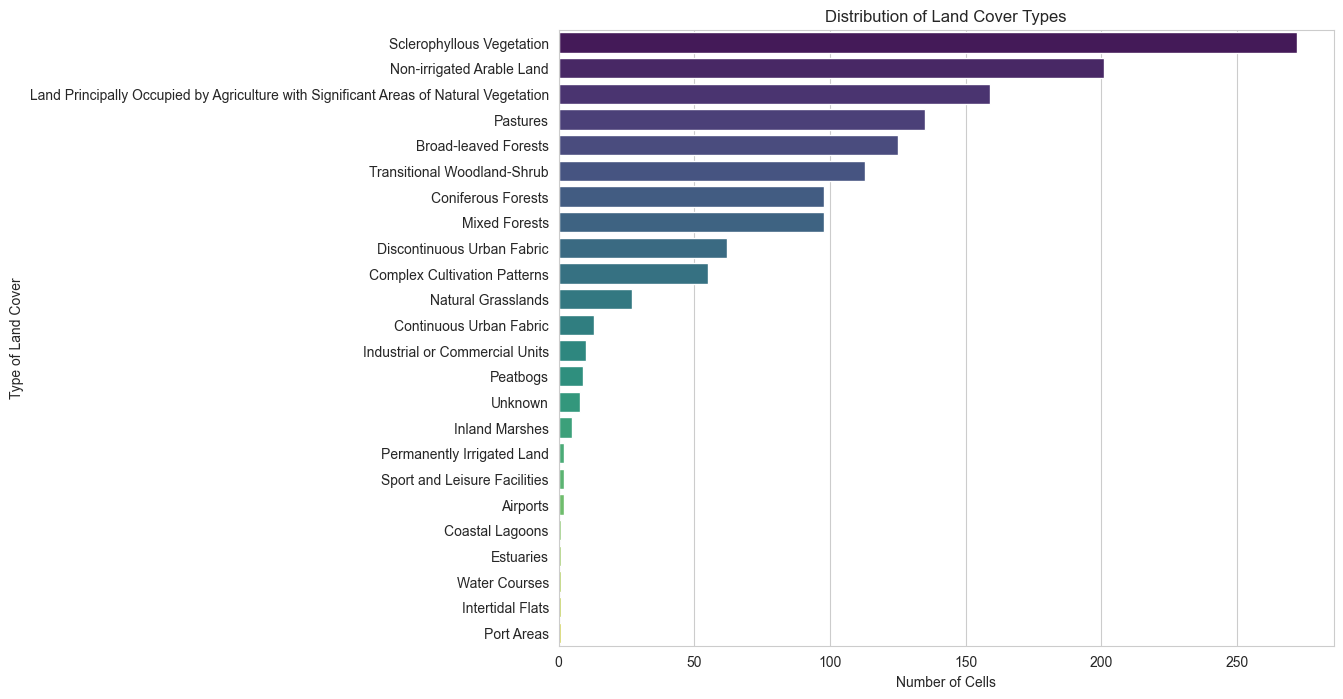

In [ ]:
plt.figure(figsize=(10, 8))
order = df['dominant_land_cover_name'].value_counts().index
sns.countplot(data=df, y='dominant_land_cover_name', order=order, palette='viridis')
plt.title("Distribution of Land Cover Types")
plt.xlabel("Number of Cells")
plt.ylabel("Type of Land Cover")
plt.show()

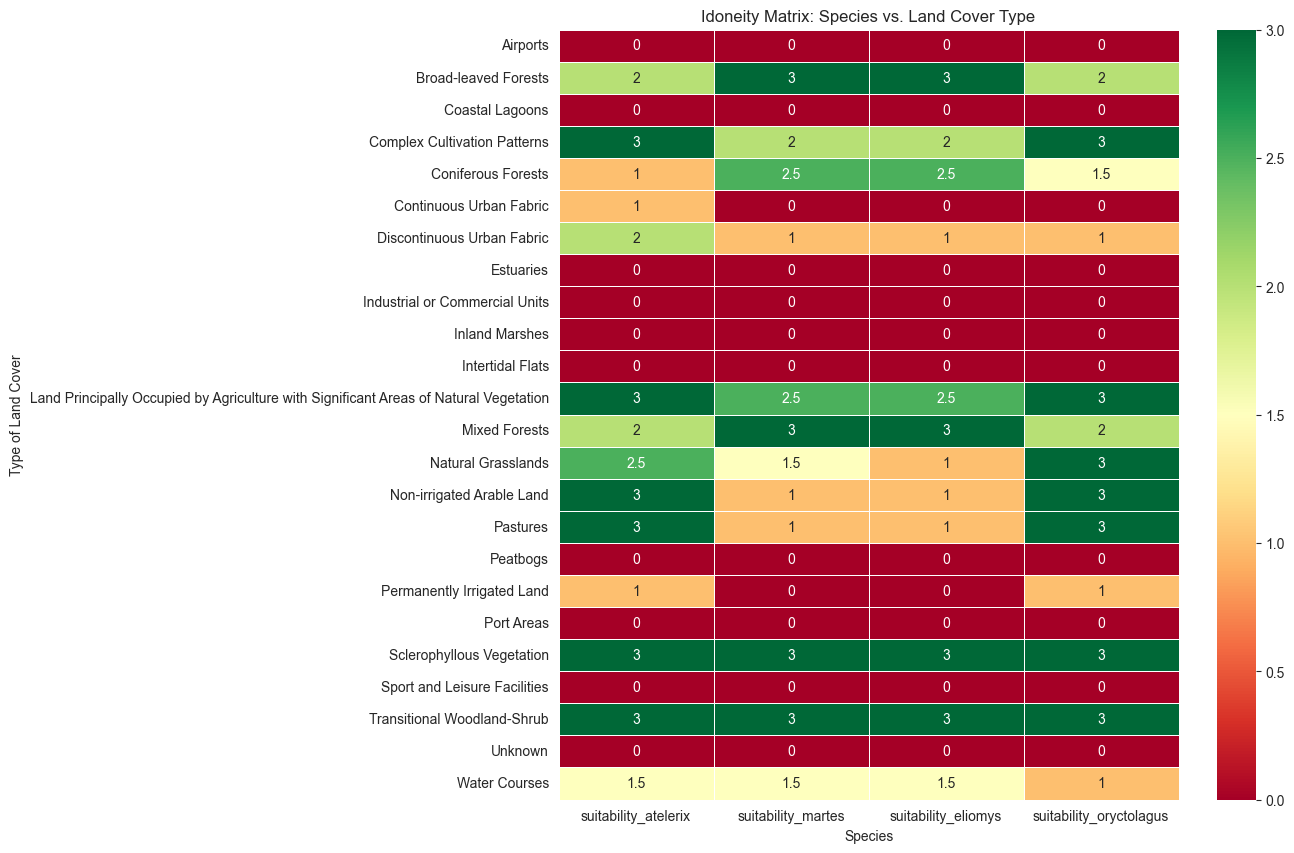

In [28]:
# Group by land cover and compute mean suitability
suitability_cols = ['suitability_atelerix', 'suitability_martes', 
                    'suitability_eliomys', 'suitability_oryctolagus']

# Compute the mean (since the rule is fixed, the mean will be the exact value)
rules_matrix = df.groupby('dominant_land_cover_name')[suitability_cols].mean()

plt.figure(figsize=(10, 10))
sns.heatmap(rules_matrix, annot=True, cmap='RdYlGn', vmin=0, vmax=3, linewidths=.5)
plt.title("Idoneity Matrix: Species vs. Land Cover Type")
plt.ylabel("Type of Land Cover")
plt.xlabel("Species")
plt.show()